In [ ]:
%matplotlib inline
# %config InlineBackend.figure_format = 'svg'
%reload_ext autoreload
%autoreload 2

In [24]:
from __future__ import division
import sys
import os
sys.path.append('../')
from modules.basics import *

from sklearn.model_selection import train_test_split 

from lumin.plotting.data_viewing import plot_rank_order_dendrogram
from lumin.optimisation.features import rf_rank_features, auto_filter_on_linear_correlation, repeated_rf_rank_features, auto_filter_on_mutual_dependence


from rfpimp import plot_corr_heatmap, feature_dependence_matrix, plot_dependence_heatmap
from sklearn.ensemble import RandomForestRegressor

In [2]:
DATA_PATH = Path('../data')

In [3]:
!python ../modules/data_import.py -d ../data/

Converting to use_cartesian coordinates
Converting to use_cartesian coordinates
Training on 200000 datapoints and validating on 50000, using 31 feats:
['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_met_px', 'PRI_met_py', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_met_pt']
Saving fold 0 with 20001 events
Saving fold 1 with 20001 events
Saving fold 2 with 20001 events
Saving fold 3 with 20001 events
Saving fold 4 with 20000 events
Saving fold 5 with 20000 events
Saving fold 6 with 19999 events
Saving fold 7 with 19999 events
Saving 

In [4]:
train_fy = FoldYielder(DATA_PATH/'train.hdf5', input_pipe=DATA_PATH/'input_pipe.pkl')
train_df = train_fy.get_df(inc_inputs=True, deprocess=True, suppress_warn=True, nan_to_num=True); train_df.head()

200000 datapoints loaded


,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_met_py,PRI_jet_subleading_px,PRI_jet_subleading_py,PRI_jet_subleading_pz,PRI_jet_leading_px,PRI_jet_leading_py,PRI_jet_leading_pz,PRI_met_pt,gen_target,gen_weight
0,0.000000,73.823997,173.461990,97.922997,0.000,0.000000,0.000,2.749,42.284000,311.565002,...,103.304375,0.000000,0.000000,0.000000,77.475060,-67.540749,16.307209,231.021011,0,0.000002
1,87.237000,16.338001,61.542999,1.197002,0.000,0.000000,0.000,2.833,1.196999,62.828003,...,5.481502,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.668000,1,0.000034
2,117.049004,61.943001,97.424004,31.950001,0.000,0.000000,0.000,2.109,1.031000,149.201996,...,38.412796,0.000000,0.000000,0.000000,16.898716,26.668795,-910.344360,38.447998,1,0.000005
3,127.556999,14.105000,92.334000,24.826000,0.000,0.000000,0.000,3.148,23.133999,99.168999,...,2.496600,0.000000,0.000000,0.000000,16.624935,-29.185017,53.425659,3.374001,1,0.000034
4,35.204998,57.668999,27.184002,87.149002,1.999,243.225998,1.079,0.670,0.797001,257.881012,...,-39.327412,43.613148,28.886652,-298.111603,-122.109093,7.162895,-55.842663,39.338001,0,0.000006


In [5]:
train_feats = train_fy.cont_feats+train_fy.cat_feats

In [6]:
df_trn, df_val = train_test_split(train_df, test_size=0.2, random_state=0, stratify=train_df.gen_target)

# Constant feats

In [7]:
const = []
for f in train_feats:
    if len(train_df[f].unique()) == 1:
        print(f)
        const += [f]
train_feats = [f for f in train_feats if f not in const]

# Hyper opt

In [8]:
vec_feats = []
for c in ['px', 'py', 'pz']:
    vec_feats += [f for f in train_feats if f == f'{f[:f.rfind("_")+1]}{c}']
len(vec_feats)

14

In [9]:
vec_feats

['PRI_tau_px',
 'PRI_lep_px',
 'PRI_met_px',
 'PRI_jet_subleading_px',
 'PRI_jet_leading_px',
 'PRI_tau_py',
 'PRI_lep_py',
 'PRI_met_py',
 'PRI_jet_subleading_py',
 'PRI_jet_leading_py',
 'PRI_tau_pz',
 'PRI_lep_pz',
 'PRI_jet_subleading_pz',
 'PRI_jet_leading_pz']

In [10]:
hl_feats = [f for f in train_feats if f.startswith('DER_')]; len(hl_feats)

13

In [11]:
ll_feats = [f for f in train_feats if f.startswith('PRI_')]; len(ll_feats)

18

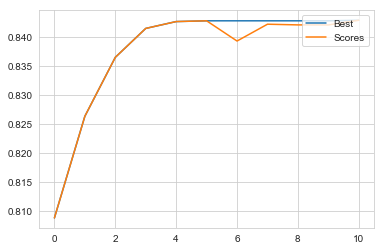

Better score schieved: min_samples_leaf @ 2 = 0.8088
Better score schieved: min_samples_leaf @ 4 = 0.8263
Better score schieved: min_samples_leaf @ 8 = 0.8365
Better score schieved: min_samples_leaf @ 16 = 0.8415
Better score schieved: min_samples_leaf @ 32 = 0.8427
Better score schieved: min_samples_leaf @ 64 = 0.8428
Better score schieved: max_features @ 0.9 = 0.8429


<Figure size 432x288 with 0 Axes>

In [17]:
from lumin.utils.misc import subsample_df
from lumin.optimisation.hyper_param import get_opt_rf_params
from collections import OrderedDict

subsample_rate = 0.1

tmp_trn = subsample_df(df_trn, 'classification', 'gen_target',
                       n_samples=int(subsample_rate*len(df_trn)), strat_key='gen_target', wgt_name='gen_weight')
rf_params, _ = get_opt_rf_params(x_trn=tmp_trn[hl_feats], y_trn=tmp_trn['gen_target'],
                                 x_val=df_val[hl_feats], y_val=df_val['gen_target'],
                                 objective='classification',
                                 w_trn=tmp_trn['gen_weight'], w_val=df_val['gen_weight'],
                                 n_estimators=40, verbose=True,
                                 params=OrderedDict({'min_samples_leaf': [2,4,8,16,32,64,128],
                                                     'max_features': [0.3,0.5,0.7,0.9]}))

# Spearman's rank order correlation

Computing Spearman's rank-order correlation coefficients


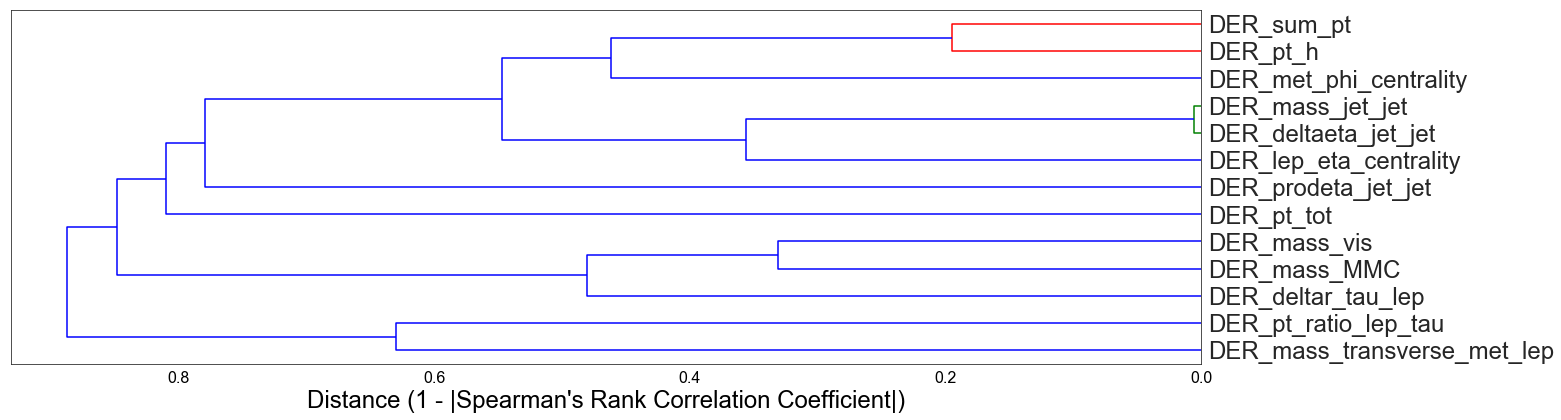

2 pairs of features found to pass correlation threshold of 0.8:
[['DER_deltaeta_jet_jet', 'DER_mass_jet_jet'], ['DER_pt_h', 'DER_sum_pt']]



Checking pair: ['DER_deltaeta_jet_jet', 'DER_mass_jet_jet']
+----------------------+-------------+-------------+
|       Removed        |  OOB Score  |  Val Score  |
+----------------------+-------------+-------------+
|         None         | 0.739±0.008 | 0.811±0.003 |
| DER_deltaeta_jet_jet | 0.735±0.005 | 0.811±0.002 |
|   DER_mass_jet_jet   | 0.738±0.004 |  0.81±0.003 |
+----------------------+-------------+-------------+
Dropping DER_deltaeta_jet_jet

Checking pair: ['DER_pt_h', 'DER_sum_pt']
+------------+-------------+-------------+
|  Removed   |  OOB Score  |  Val Score  |
+------------+-------------+-------------+
|    None    | 0.745±0.008 | 0.812±0.002 |
|  DER_pt_h  | 0.742±0.008 | 0.812±0.001 |
| DER_sum_pt | 0.744±0.008 | 0.811±0.002 |
+------------+-------------+-------------+

1 features removed from starting list of 13, 12 features remain

Recomputing Spearman's rank-order correlation coefficients on filtered features


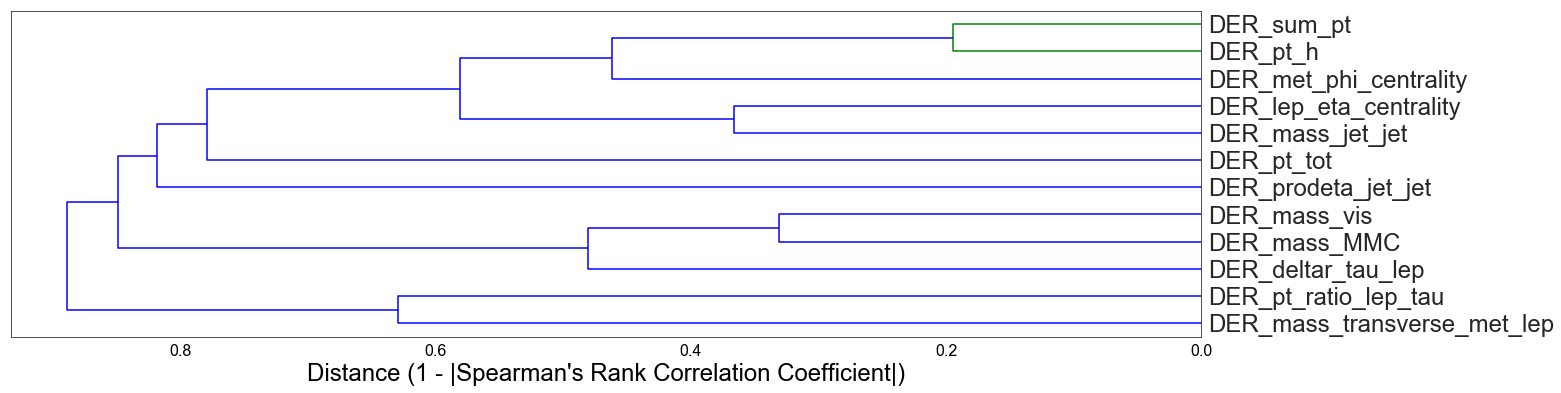

1 pairs of features still found to pass correlation threshold of 0.8. You may wish to rerun this function on the filtered features.

Comparing RF scores, higher = better
All features:		0.806±0.009
Filtered features:	0.808±0.007

Filtering took 10.985 seconds


In [21]:
filtered_feats = auto_filter_on_linear_correlation(train_df=df_trn, val_df=df_val,
                                                   check_feats=hl_feats, subsample_rate=0.01, n_rfs=5,
                                                   corr_threshold=0.8, rf_params=rf_params, optimise_rf=False,
                                                   objective='classification', targ_name='gen_target',
                                                   wgt_name='gen_weight', strat_key='gen_target')

# Permutation Importance

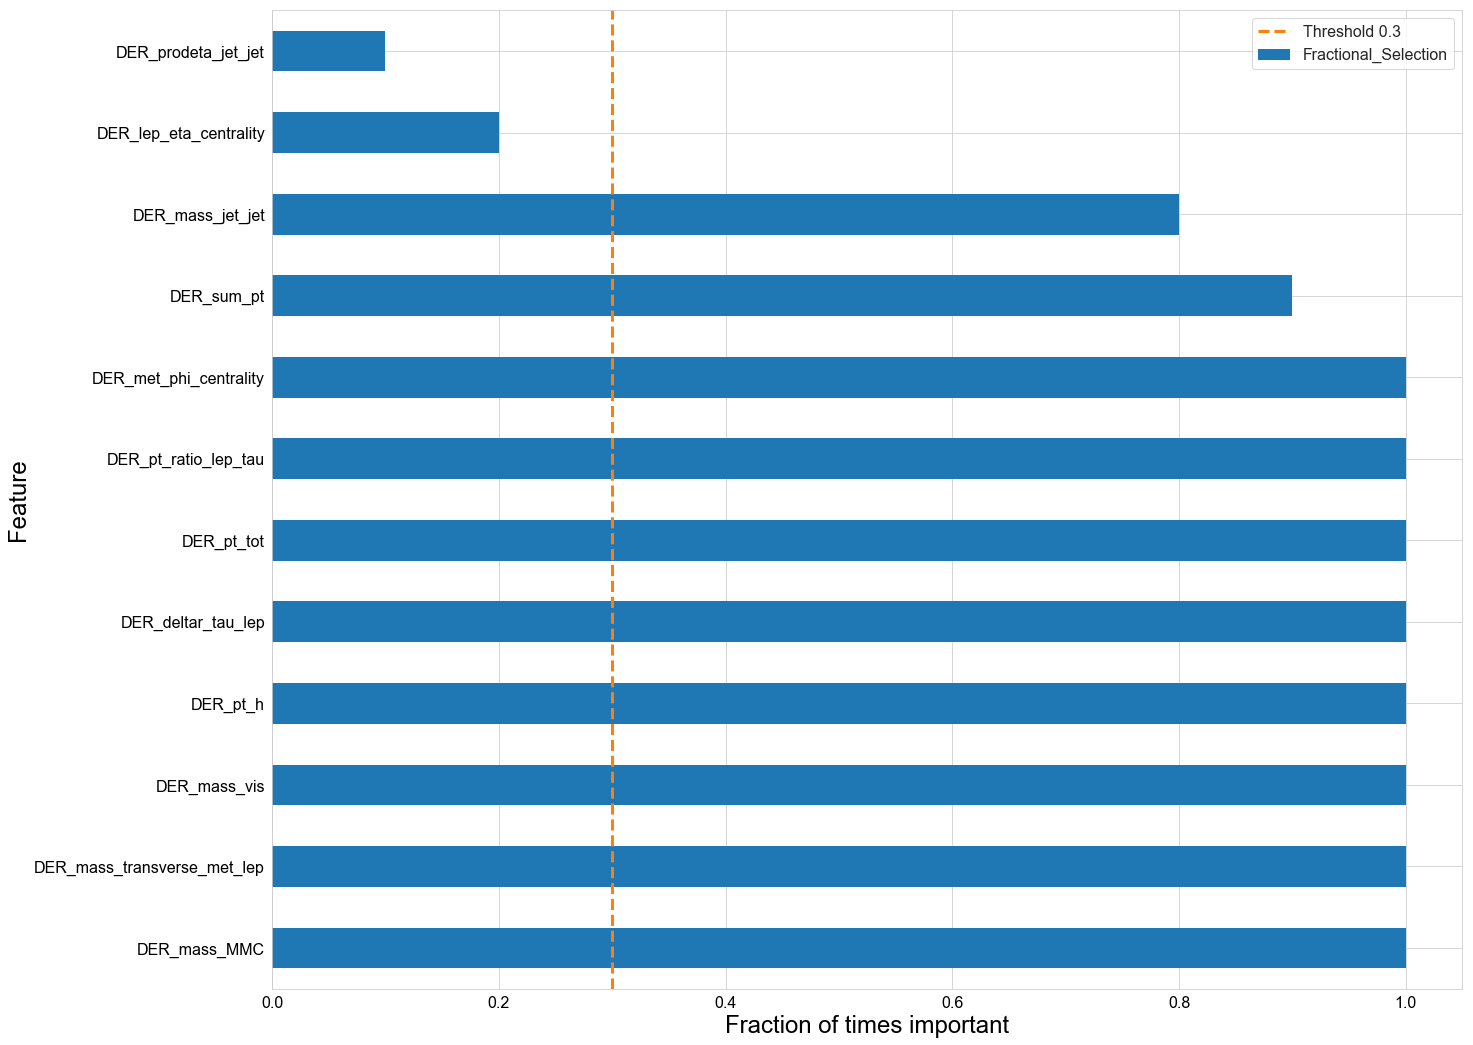


10 features found with fractional selection greater than 0.3:
 ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_sum_pt', 'DER_mass_jet_jet'] 



Comparing RF scores, higher = better
All features:		0.842±0.001
Selected features:	0.846±0.002


In [22]:
import_feats, fi = repeated_rf_rank_features(train_df=df_trn, val_df=df_val,
                                             n_reps=10, min_frac_import=0.3,
                                             rf_params=OrderedDict({'min_samples_leaf': [2,4,8,16,32,64,128],
                                                                    'max_features': [0.3,0.5,0.7,0.9]}),
                                             strat_key='gen_target', objective='classification',
                                             subsample_rate=subsample_rate, resample_val=True,
                                             train_feats=filtered_feats, wgt_name='gen_weight', importance_cut=0.001,
                                             n_rfs=5, n_threads=5)

# Mutual dependence

Computing mutual dependencies


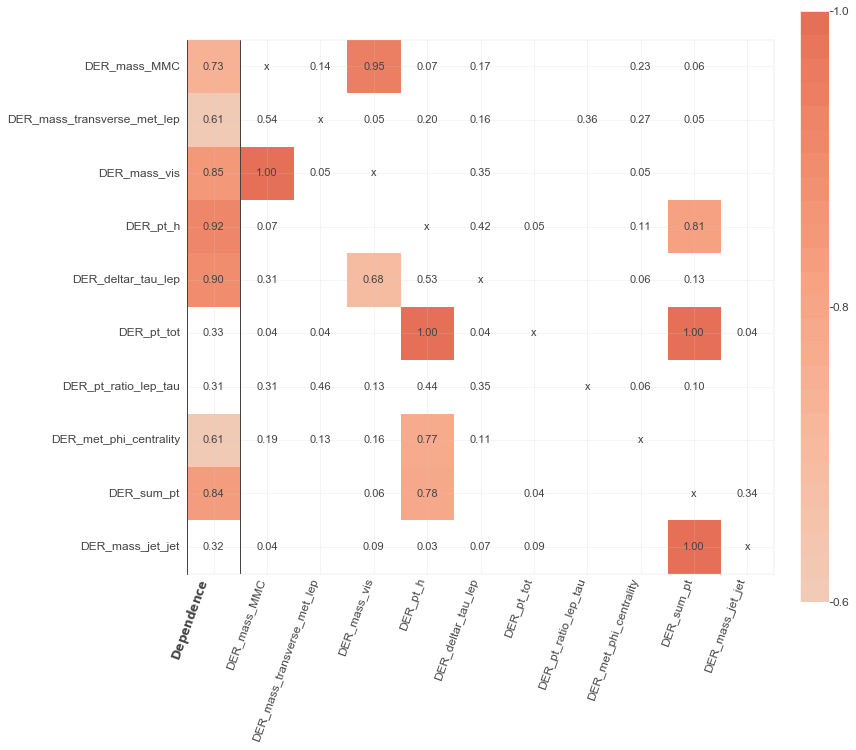


4 predictable features found to pass mutual dependence threshold of 0.8

Optimising RF


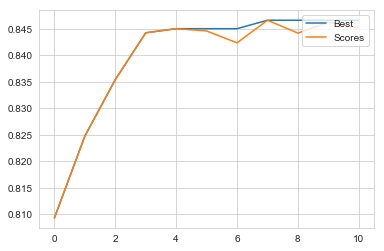

Better score schieved: min_samples_leaf @ 2 = 0.8093
Better score schieved: min_samples_leaf @ 4 = 0.8248
Better score schieved: min_samples_leaf @ 8 = 0.8354
Better score schieved: min_samples_leaf @ 16 = 0.8442
Better score schieved: min_samples_leaf @ 32 = 0.8450
Better score schieved: max_features @ 0.3 = 0.8466

Checking ['DER_sum_pt', 'DER_deltar_tau_lep']
+--------------------+---------------+---------------+
|      Removed       |   OOB Score   |   Val Score   |
+--------------------+---------------+---------------+
|        None        |  0.7872±0.001 | 0.8451±0.0008 |
|     DER_sum_pt     | 0.7831±0.0009 | 0.8439±0.0004 |
| DER_deltar_tau_lep |  0.7832±0.001 | 0.8427±0.0004 |
+--------------------+---------------+---------------+

4 predictable features found to pass mutual dependence threshold of 0.8

Checking ['DER_pt_h', 'DER_mass_vis']
+--------------+---------------+---------------+
|   Removed    |   OOB Score   |   Val Score   |
+--------------+---------------+--------

<Figure size 432x288 with 0 Axes>

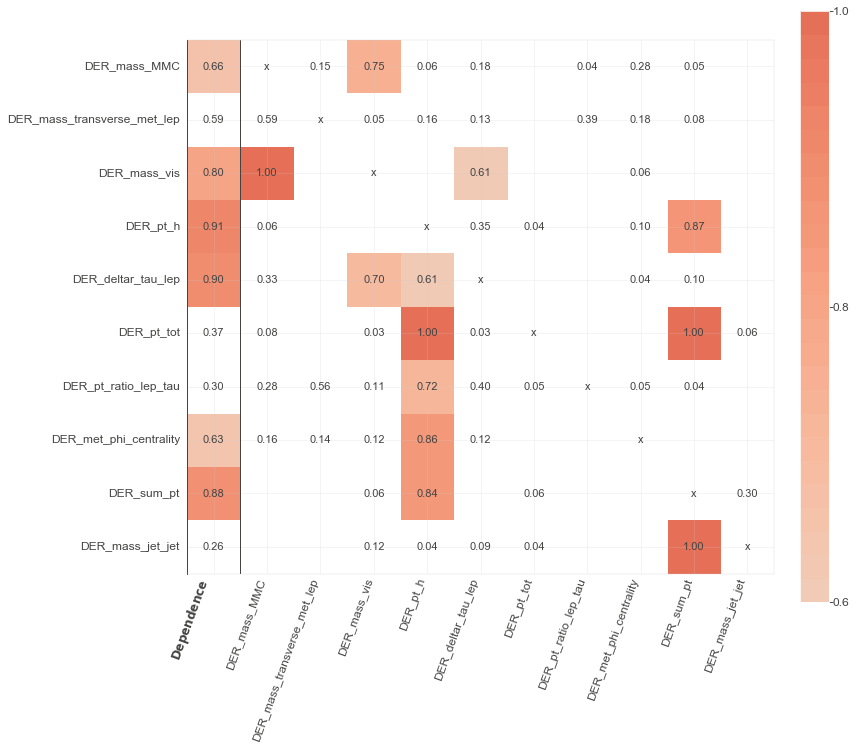


3 predictable features found to pass mutual dependence threshold of 0.8

Filtering took 66.545 seconds


In [23]:
filtered_feats = auto_filter_on_mutual_dependence(train_df=df_trn, val_df=df_val,
                                                  check_feats=import_feats,
                                                  objective='classification', targ_name='gen_target',
                                                  strat_key='gen_target', wgt_name='gen_weight',
                                                  subsample_rate=0.3,
                                                  rf_params=OrderedDict({'min_samples_leaf': [2,4,8,16,32,64,128],
                                                                         'max_features': [0.3,0.5,0.7,0.9]}),
                                                  optimise_rf=True)